In [62]:
import requests
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.ticker import PercentFormatter

In [32]:
####### Helper functions

# Clean line of output from API
def clean_line(line): 
    line = line.replace('"', '')
    line = line.replace('[', '')
    line = line.replace(']', '')
    
    return line

# Clean df of unwanted data
def clean_df(df):
    temp_df = df.copy()
    temp_df = temp_df[temp_df.event.isin(['Rated Blitz game', 'Rated Rapid game'])]
    temp_df = temp_df[temp_df.variant=='Standard']
    temp_df = temp_df[(temp_df.white_elo * 1.2 > temp_df.black_elo) & (temp_df.black_elo * 1.2 > temp_df.white_elo)]
    
    return temp_df

# Create 3 lagged versions for the prev game, 2 prev games, 3 prev games
def get_lagged_df(df):
    
    # Lag df multiple times
    df_lag_1 = df[['date', 'points']].shift(-1)
    df_lag_2 = df[['date', 'points']].shift(-2)
    df_lag_3 = df[['date', 'points']].shift(-3)

    # Combine
    df_lag_1.columns = ['date_lag_1', 'points_lag_1']
    df_lag_2.columns = ['date_lag_2', 'points_lag_2']
    df_lag_3.columns = ['date_lag_3', 'points_lag_3']
    
    df_concatenated = pd.concat([df, df_lag_1, df_lag_2, df_lag_3], axis=1)

    return df_concatenated


# Logic to check if games played on the same day, and if games were wins or losses leading up to tgt game
def add_dates_wins_losses_checks(df):
    # Dates
    df['same_3_dates'] = df.apply(lambda x: x.date == x.date_lag_1 == x.date_lag_2 == x.date_lag_3, axis = 1)
    df['same_2_dates'] = df.apply(lambda x: x.date == x.date_lag_1 == x.date_lag_2, axis = 1)
    df['same_1_date'] = df.apply(lambda x: x.date == x.date_lag_1, axis = 1)
    
    # Lossses 
    df['3_losses'] = df.apply(lambda x: 0 == x.points_lag_1 == x.points_lag_2 == x.points_lag_3, axis = 1)
    df['2_losses'] = df.apply(lambda x: 0 == x.points_lag_1 == x.points_lag_2, axis = 1)
    df['1_loss'] = df.apply(lambda x: 0 == x.points_lag_1, axis = 1)

    # Wins 
    df['3_wins'] = df.apply(lambda x: 1 == x.points_lag_1 == x.points_lag_2 == x.points_lag_3, axis = 1)
    df['2_wins'] = df.apply(lambda x: 1 == x.points_lag_1 == x.points_lag_2, axis = 1)
    df['1_win'] = df.apply(lambda x: 1 == x.points_lag_1, axis = 1)
    
    return df


In [4]:
def get_games(player='eono619', games=100):
    
    # Make GET request
    url = "https://lichess.org/api/games/user/" + player
    
    resp = requests.get(url,
      params={
        'max': games # I'm only getting the most recent 10 puzzles you completed. You can get more if you'd like.
      },
    )
    
    # Decode and Split
    split_resp = resp.content.decode().split('\n')

    
    # Containers for relevant Information 
    game_type_container = []
    date_container = []
    white_container = []
    black_container = []
    result_container = []
    white_elo_container = []
    black_elo_container = []
    variant_container = []
    points_container = []


    # Parse through decoded response 
    for line in split_resp: 

        cleaned = clean_line(line)

        # Collect Data
        if cleaned.split(' ')[0] == 'Event':
            game_type_container.append(cleaned.split(' ', 1)[1])

        if cleaned.split(' ')[0] == 'Date':
            date_container.append(cleaned.split(' ', 1)[1])

        if cleaned.split(' ')[0] == 'White':
            white_container.append(cleaned.split(' ', 1)[1])

        if cleaned.split(' ')[0] == 'Black':
            black_container.append(cleaned.split(' ', 1)[1])

        if cleaned.split(' ')[0] == 'Result':
            result_container.append(cleaned.split(' ', 1)[1])

        if cleaned.split(' ')[0] == 'WhiteElo':
            white_elo_container.append(cleaned.split(' ', 1)[1])

        if cleaned.split(' ')[0] == 'BlackElo':
            black_elo_container.append(cleaned.split(' ', 1)[1])

        if cleaned.split(' ')[0] == 'Variant':
            variant_container.append(cleaned.split(' ', 1)[1])

    # Create DataFrame
    d = {'event': game_type_container, 
         'date': date_container, 
         'white_player': white_container, 
         'black_player': black_container, 
         'result': result_container, 
         'white_elo': white_elo_container,
         'black_elo': black_elo_container, 
         'variant': variant_container

    }
    
    df = pd.DataFrame(d)
    
    # Logic for a win
    for (result, white_player, black_player) in zip(df['result'], df['white_player'], df['black_player']):
        if result == '1-0':
            if white_player == player:
                points_container.append(1)
            else: 
                points_container.append(0)
        elif result == '0-1':
            if black_player == player:
                points_container.append(1)
            else: 
                points_container.append(0)
        else:
            points_container.append(0.5)

    df['points'] = points_container
    df = df[(df.white_elo != '?') & (df.black_elo != '?')]
    df['white_elo'] = pd.to_numeric(df['white_elo'])
    df['black_elo'] = pd.to_numeric(df['black_elo'])
    df['elo_diff'] = abs(df['white_elo'] - df['black_elo'])


    return df

In [111]:
# Pull games
# Isaac1969
# DoktorMatt
# eono619
df = get_games('DoktorMatt', 1000)

# Clean dataframe
df = clean_df(df)

# Add lagged games
all_df = get_lagged_df(df)

# Add dates, wins, and losses checks
final_df =  add_dates_wins_losses_checks(all_df)


In [112]:
final_df[['date', 'points', 'points_lag_1', 'points_lag_2', 'points_lag_3', '1_win', '2_wins', '3_wins']].head(20)

,date,points,points_lag_1,points_lag_2,points_lag_3,1_win,2_wins,3_wins
0,2021.08.23,1.0,0.0,0.0,1.0,False,False,False
1,2021.08.23,0.0,0.0,1.0,1.0,False,False,False
2,2021.08.23,0.0,1.0,1.0,1.0,True,True,True
3,2021.08.23,1.0,1.0,1.0,1.0,True,True,True
4,2021.08.23,1.0,1.0,1.0,0.0,True,True,False
5,2021.08.23,1.0,1.0,0.0,0.0,True,False,False
6,2021.08.22,1.0,0.0,0.0,1.0,False,False,False
7,2021.08.22,0.0,0.0,1.0,0.0,False,False,False
8,2021.08.22,0.0,1.0,0.0,1.0,True,False,False
9,2021.08.22,1.0,0.0,1.0,0.0,False,False,False


In [113]:
d = {'3_losses': [final_df[final_df['3_losses']].points.mean()],
     '2_losses': [final_df[final_df['2_losses']].points.mean()],
     '1_loss': [final_df[final_df['1_loss']].points.mean()],
     'overall_avg': [final_df['points'].mean()], 
     '1_win': [final_df[final_df['1_win']].points.mean()],
     '2_wins': [final_df[final_df['2_wins']].points.mean()],
     '3_wins': [final_df[final_df['3_wins']].points.mean()]
}

results_df = pd.DataFrame(d)


In [114]:
melted_results = pd.melt(results_df)

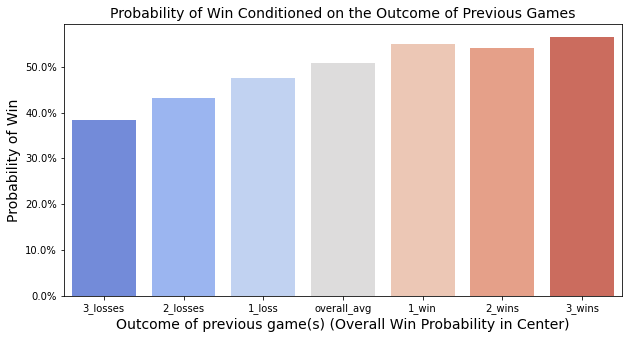

In [115]:
plt.figure(figsize=(10, 5))

sns.barplot(x='variable', y='value', data=melted_results, palette='coolwarm')
#plt.ylim([.4,.6])
plt.title('Probability of Win Conditioned on the Outcome of Previous Games', fontsize=14)
plt.ylabel('Probability of Win', fontsize=14)
plt.xlabel('Outcome of previous game(s) (Overall Win Probability in Center)', fontsize=14)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=1))


plt.show()